# 초기 설정 및 데이터 로드

In [1]:
# --- 1. 라이브러리 임포트 ---
# 데이터 핸들링 및 수치 계산
import pandas as pd
import numpy as np
# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
# 모델링
import lightgbm as lgb
# 전처리 및 평가
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
# 기타
import random
import warnings

# --- 2. 환경 설정 ---
# 랜덤 시드 고정으로 결과 재현성 보장
np.random.seed(1234)
random.seed(1234)
# 불필요한 경고 메시지 무시
warnings.filterwarnings("ignore")

# --- 3. 데이터셋 로드 ---
# Kaggle 경로에서 데이터 불러오기
train_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
submission = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")

print("Setup and data loading complete.")

Setup and data loading complete.


# 데이터 탐색 및 전처리

In [2]:
# --- 1. 데이터 탐색 ---
print("--- Initial Data Exploration ---")
# 데이터 구조 및 타입 확인
print("Train Data Head:\n", train_df.head())
print("\nData Types:\n", train_df.dtypes.head())
# 결측치 확인 (결측치가 있는 컬럼만 내림차순 출력)
print("\nTrain Missing Values:\n", train_df.isnull().sum()[train_df.isnull().sum() > 0].sort_values(ascending=False))
print("\nTest Missing Values:\n", test_df.isnull().sum()[test_df.isnull().sum() > 0].sort_values(ascending=False))

# --- 2. 범주형 변수 전처리 (Label Encoding) ---
# 훈련 데이터와 테스트 데이터의 'object' 타입 컬럼을 식별
train_categories = train_df.columns[train_df.dtypes=="object"]
test_categories = test_df.columns[test_df.dtypes=="object"]

# 훈련 데이터의 범주형 변수에 대해 결측치 처리 및 레이블 인코딩 수행
for cat in train_categories:
    train_df[cat] = train_df[cat].fillna("missing") # 결측치를 'missing'으로 대체
    le = LabelEncoder().fit(train_df[cat])
    train_df[cat] = le.transform(train_df[cat])
    train_df[cat] = train_df[cat].astype("category") # LightGBM 효율을 위해 타입 변경

# 테스트 데이터에 대해서도 동일한 작업 수행
for cat in test_categories:
    test_df[cat] = test_df[cat].fillna("missing")
    le = LabelEncoder().fit(test_df[cat])
    test_df[cat] = le.transform(test_df[cat])
    test_df[cat] = test_df[cat].astype("category")

print("\nCategorical feature encoding complete.")

--- Initial Data Exploration ---
Train Data Head:
    Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleTyp

# 모델 학습 및 평가

In [3]:
# --- 1. 모델 학습 준비 ---
# 교차 검증 설정 (3-Fold)
kf = KFold(n_splits=3)
# LightGBM 하이퍼파라미터 설정
lgbm_params = {"objective": "regression", "random_seed": 1234}
# 설명 변수(X)와 목적 변수(Y) 분리
train_X = train_df.drop(["SalePrice", "Id"], axis=1)
train_Y = train_df["SalePrice"]

# --- 2. 교차 검증을 통한 모델 학습 및 평가 ---
models = []
rmses = []
oof = np.zeros(len(train_X)) # Out-of-Fold 예측값 저장용 배열

for fold, (train_index, val_index) in enumerate(kf.split(train_X)):
    print(f"--- Fold {fold+1} ---")
    # 훈련/검증 데이터 분리
    X_train, X_valid = train_X.iloc[train_index], train_X.iloc[val_index]
    y_train, y_valid = train_Y.iloc[train_index], train_Y.iloc[val_index]
    
    # LightGBM 데이터셋 생성
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    # 모델 학습 (100 라운드 동안 성능 향상 없으면 조기 종료)
    model_lgb = lgb.train(
        params=lgbm_params, train_set=lgb_train, valid_sets=[lgb_eval],
        num_boost_round=1000, callbacks=[lgb.early_stopping(100, verbose=True)]
    )
    
    # 예측 및 성능 평가 (RMSLE)
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))
    print(f"Fold {fold+1} RMSLE: {tmp_rmse}")
    
    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

# --- 3. 최종 성능 확인 ---
print(f"\nBaseline Average RMSLE: {sum(rmses)/len(rmses)}")

--- Fold 1 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2963
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 179726.031860
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's l2: 5.37132e+08
Fold 1 RMSLE: 0.12800381488672496
--- Fold 2 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2984
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 180923.739979
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[290]	valid_0's l2: 8

# 결과 분석

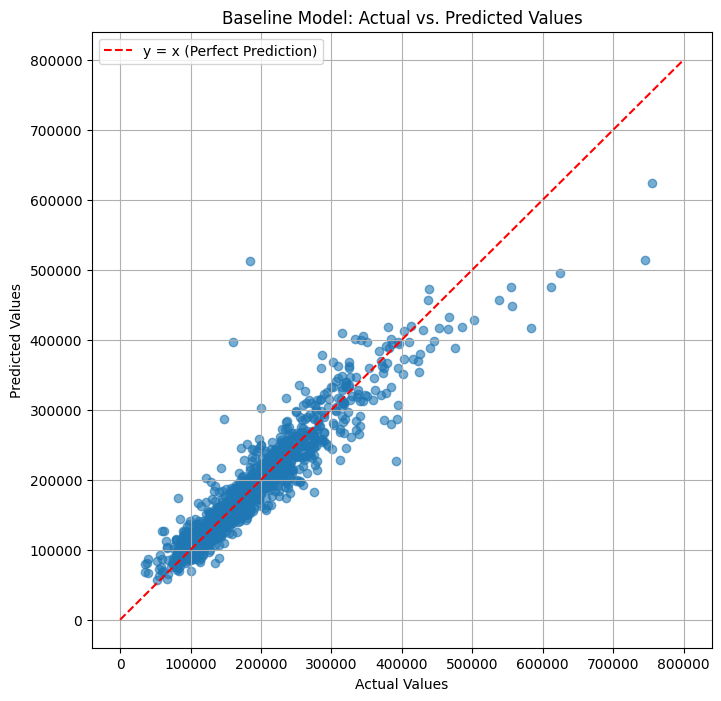

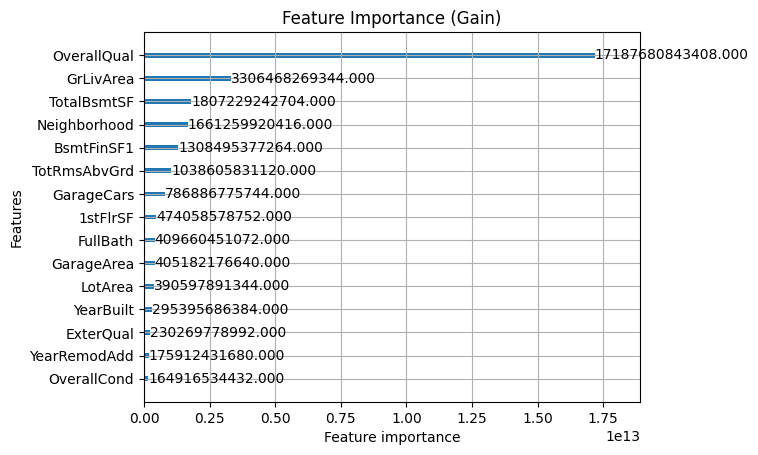

In [4]:
# --- 1. 실제값 vs 예측값 시각화 ---
actual_pred_df = pd.DataFrame({'actual': train_Y, 'pred': oof})
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(actual_pred_df['actual'], actual_pred_df['pred'], alpha=0.6)
ax.plot([0, 800000], [0, 800000], 'r--', label='y = x (Perfect Prediction)') # y=x 기준선
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_title('Baseline Model: Actual vs. Predicted Values')
ax.legend()
plt.grid(True)
plt.show()

# --- 2. 변수 중요도 시각화 ---
# 첫 번째 폴드 모델의 변수 중요도를 예시로 확인
lgb.plot_importance(models[0], importance_type="gain", max_num_features=15, title="Feature Importance (Gain)")
plt.show()

# 전처리 1 - 타겟 변수 로그 변환 및 성능 재확인

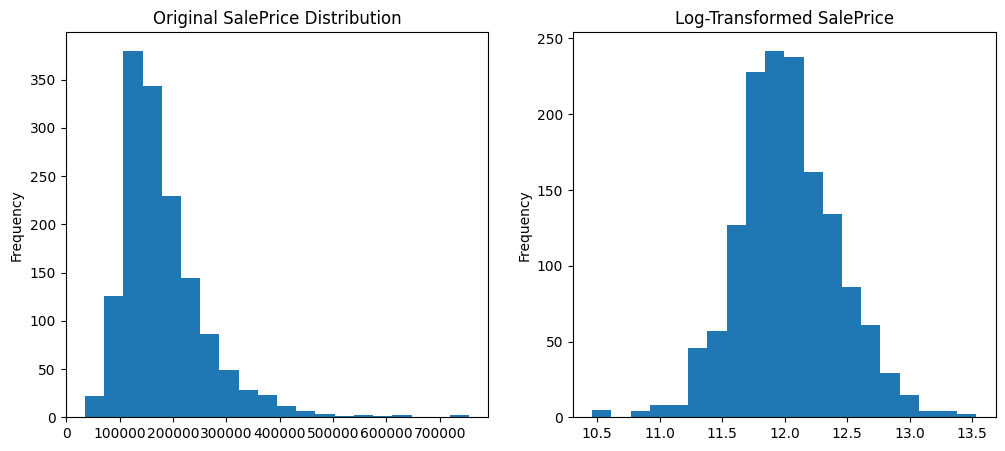

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2963
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 12.017607
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2984
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 12.025976
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3005
[LightGBM] [Info] Number of data points in the train set: 974, number of used features: 75
[LightGBM] [Info] Start trainin

In [5]:
# --- 1. 타겟 변수 분포 확인 및 로그 변환 ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
train_df["SalePrice"].plot.hist(bins=20, ax=axes[0], title="Original SalePrice Distribution")
np.log(train_df['SalePrice']).plot.hist(bins=20, ax=axes[1], title="Log-Transformed SalePrice")
plt.show()

# --- 2. 로그 변환된 타겟으로 모델 재학습 및 평가 ---
# 데이터셋 재구성
train_df["SalePrice_log"] = np.log(train_df["SalePrice"])
train_X = train_df.drop(["SalePrice", "SalePrice_log", "Id"], axis=1)
train_Y = train_df["SalePrice_log"] # 로그 변환된 값을 타겟으로 사용

# 모델 재학습 (코드는 베이스라인과 동일, 타겟 변수만 다름)
models_log, rmses_log, oof_log = [], [], np.zeros(len(train_X))
for fold, (train_index, val_index) in enumerate(kf.split(train_X)):
    X_train, X_valid = train_X.iloc[train_index], train_X.iloc[val_index]
    y_train, y_valid = train_Y.iloc[train_index], train_Y.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(
        params=lgbm_params, train_set=lgb_train, valid_sets=[lgb_eval],
        num_boost_round=1000, callbacks=[lgb.early_stopping(100, verbose=False)] # 로그 출력 생략
    )
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    # 타겟이 이미 로그 스케일이므로 RMSE를 바로 계산
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    rmses_log.append(tmp_rmse)

print(f"Average RMSE after log-transformation: {sum(rmses_log)/len(rmses_log)}")

# 전처리 2 - 결측치가 많은 변수 처리

In [6]:
# 원본 데이터를 다시 로드하여 작업
tmp_train_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
tmp_test_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

# 처리할 컬럼 목록
cols = ["PoolQC", "MiscFeature", "Alley"]

# 훈련/테스트 데이터에 대해 '고급 시설 보유 개수' 특성 생성
for d in [tmp_train_df, tmp_test_df]:
    d['hasHighFacility'] = d[cols].notnull().astype(int).sum(axis=1)

# 기존 데이터프레임에 새로운 특성 추가 및 원본 컬럼 삭제
train_df['hasHighFacility'] = tmp_train_df['hasHighFacility'].values
test_df['hasHighFacility']  = tmp_test_df['hasHighFacility'].values
train_df.drop(cols, axis=1, inplace=True)
test_df.drop(cols, axis=1, inplace=True)

print("'hasHighFacility' feature created. Original columns dropped.")
print(train_df['hasHighFacility'].value_counts())

'hasHighFacility' feature created. Original columns dropped.
hasHighFacility
0    1313
1     142
2       5
Name: count, dtype: int64


# 전처리 3 - 이상치 탐색 및 시각화

Outlier counts using 3-sigma rule:
1stFlrSF: 12 outliers
2ndFlrSF: 4 outliers
3SsnPorch: 23 outliers
BedroomAbvGr: 14 outliers
BsmtFinSF1: 6 outliers
BsmtFinSF2: 50 outliers
BsmtFullBath: 16 outliers
BsmtHalfBath: 82 outliers
BsmtUnfSF: 11 outliers
EnclosedPorch: 51 outliers
Fireplaces: 5 outliers
GarageArea: 7 outliers
GarageYrBlt: 1 outliers
GrLivArea: 16 outliers
HalfBath: 12 outliers
KitchenAbvGr: 68 outliers
LotArea: 13 outliers
LotFrontage: 12 outliers
LowQualFinSF: 20 outliers
MasVnrArea: 32 outliers
MiscVal: 8 outliers
OpenPorchSF: 27 outliers
PoolArea: 7 outliers
SalePrice: 22 outliers
SalePrice_log: 12 outliers
ScreenPorch: 55 outliers
TotRmsAbvGrd: 12 outliers
TotalBsmtSF: 10 outliers
WoodDeckSF: 22 outliers
hasHighFacility: 5 outliers


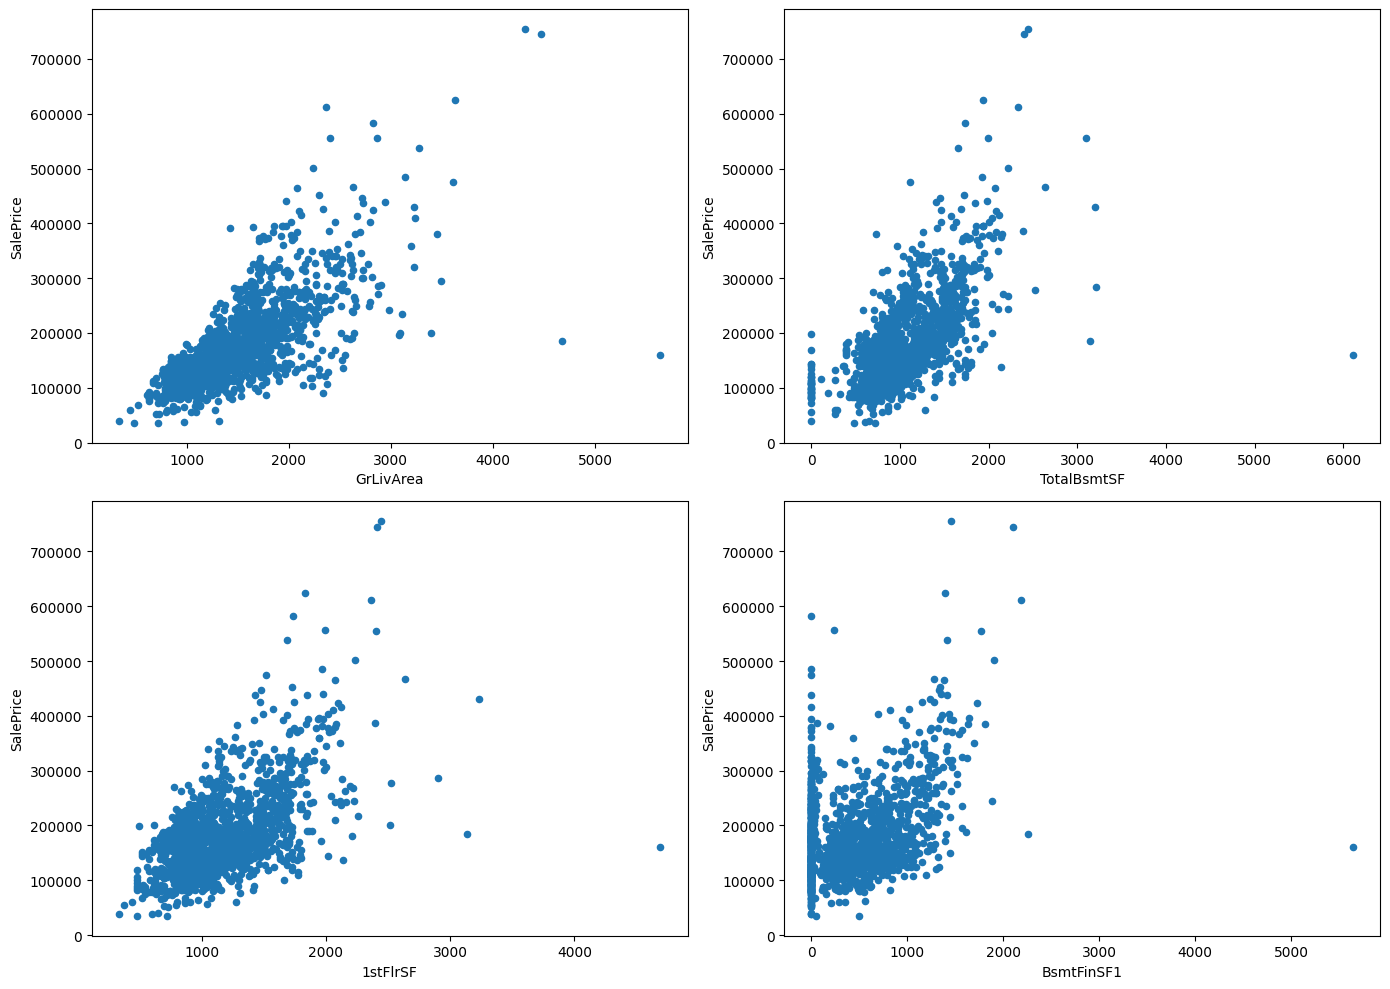

In [7]:
# --- 1. 이상치 탐색 ---
# 분석 대상 수치형 변수 식별
train_df_num = train_df.select_dtypes(include=[np.number])
nonratio_features = ["Id", "MSSubClass", "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd", "MoSold", "YrSold"]
num_features = sorted(list(set(train_df_num) - set(nonratio_features)))

print("Outlier counts using 3-sigma rule:")
for col in num_features:
    # 평균 ± 3 * 표준편차를 벗어나는 데이터 개수 확인
    outlier_count = len(train_df[(np.abs(train_df[col] - train_df[col].mean()) > (3 * train_df[col].std()))])
    if outlier_count > 0:
        print(f"{col}: {outlier_count} outliers")

# --- 2. 주요 이상치 시각화 ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
train_df.plot.scatter(x="GrLivArea", y="SalePrice", ax=axes[0, 0])
train_df.plot.scatter(x="TotalBsmtSF", y="SalePrice", ax=axes[0, 1])
train_df.plot.scatter(x="1stFlrSF", y="SalePrice", ax=axes[1, 0])
train_df.plot.scatter(x="BsmtFinSF1", y="SalePrice", ax=axes[1, 1])
plt.tight_layout()
plt.show()

# 전처리 3 - 이상치 제거 및 최종 모델 학습

In [8]:
# --- 1. 이상치 제거 ---
# 시각적 분석을 기반으로 극단적인 값들을 제거
original_rows = len(train_df)
train_df = train_df[train_df['GrLivArea'] < 4500]
train_df = train_df[train_df['TotalBsmtSF'] < 3000]
train_df = train_df[train_df['1stFlrSF'] < 2500]
train_df = train_df[train_df['BsmtFinSF1'] < 2000]
train_df = train_df[train_df['LotArea'] < 100000]
print(f"Removed {original_rows - len(train_df)} outlier rows.")

# --- 2. 모든 전처리가 적용된 데이터로 최종 모델 학습 ---
# 데이터셋 재구성
train_df["SalePrice_log"] = np.log(train_df["SalePrice"])
train_X = train_df.drop(["SalePrice", "SalePrice_log", "Id"], axis=1)
train_Y = train_df["SalePrice_log"]

# 최종 모델 학습 및 평가
final_models, final_rmses, final_oof = [], [], np.zeros(len(train_X))
for fold, (train_index, val_index) in enumerate(kf.split(train_X)):
    X_train, X_valid = train_X.iloc[train_index], train_X.iloc[val_index]
    y_train, y_valid = train_Y.iloc[train_index], train_Y.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(
        params=lgbm_params, train_set=lgb_train, valid_sets=[lgb_eval],
        num_boost_round=1000, callbacks=[lgb.early_stopping(100, verbose=False)]
    )
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    final_rmses.append(tmp_rmse)

print(f"\nFinal Average RMSE after all preprocessing: {sum(final_rmses)/len(final_rmses)}")

Removed 15 outlier rows.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2948
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 72
[LightGBM] [Info] Start training from score 12.010615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2942
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 72
[LightGBM] [Info] Start training from score 12.018820
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2987
[LightGBM] [Info] Number of data points in the train set: 964, number of used features: 73
[Light